[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1hLCzw_T1HiHgXW1jj2iSNxF33bu4mWFb?usp=sharing)

# Processing Dataset

Because github can't accomodate files above 100 mb,  so dataset file need to uploaded to cloud storage. In this case, we use Google Drive. To acsess the file we need to mount it to Google Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/My Drive/Capstone Project/

/content/drive/My Drive/Capstone Project


In the section below, there is a code to unzip the dataset file.

In [ ]:
import zipfile
import os
# Extract the archive
local_zip = './dataset_binary_ori.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/CNN letter Dataset')
zip_ref.close()

To check the dataset that has been imported, run this code below.

In [ ]:
import os

base_dir = 'tmp/CNN letter Dataset/dataset_binary_ori/'

class_0_dir = os.path.join(base_dir, '0')
class_1_dir = os.path.join(base_dir, '1')
class_O_dir = os.path.join(base_dir, 'O')

print('total training 0 images:', len(os.listdir(class_0_dir)))
print('total training 1 images:', len(os.listdir(class_1_dir)))
print('total training O images:', len(os.listdir(class_O_dir)))

class_0_files = os.listdir(class_0_dir)
print(class_0_files[:10])

class_1_files = os.listdir(class_1_dir)
print(class_1_files[:10])

class_O_files = os.listdir(class_O_dir)
print(class_O_files[:10])

total training 0 images: 287
total training 1 images: 630
total training O images: 118
['B2130UFD_jpg.rf.de4fec7252c0ce9f6f6a9974ef3b3242.jpgtest6.jpg', 'PHOTO-2022-05-17-16-44-24_jpg.rf.6c680fd260272e15a9ffab401254bd02.jpgtest4.jpg', 'plat--19-_jpg.rf.7798c30ebc9f4d90c366fbd452b0523e.jpgtest6.jpg', 'plat-129-1_jpg.rf.2ed13e8cb3ab8f824edb987fcb13aa27.jpgtest4.jpg', 'B1059KCT-2-_jpg.rf.b5a93fffa6661f2572573d8232a811e3.jpgtest4 - Copy.jpg', 'BK1110W_jpg.rf.97ee2c7f68cdb1f328ef9124dcffee8b.jpgtest6.jpg', '20220517_123540_jpg.rf.81f13f5fd581bcf5784b152723eaef8b.jpgtest4.jpg', '2022-05-15-10_12_36-20220514_112722-mp4---VLC-media-player_jpg.rf.f84694e6efc999df4dabd3a243773491.jpgtest3.jpg', 'DA1401CE_jpg.rf.a0cba506815f42d2a15135592191a684.jpgtest7.jpg', 'plat-78-1_jpg.rf.a04494b648071e700a070b90d9775e79.jpgtest4.jpg']
['IMG-20220515-WA0048_jpg.rf.349042fe794163ac7c0172aa8141b623.jpgtest8.jpg', 'plat--38-_jpg.rf.ec6c5cf8a1fb2d7ea29b258e76df55a0.jpgtest3.jpg', 'plat-58-1_jpg.rf.9c571aceee1348

# Model

In this section below, we create layer for the model.

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 64x64 with 1 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', ),# kernel_regularizer='l1'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(36, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        3

In [ ]:
# Set the training parameters
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

# Image Preprocessing

In this section, we will going to use `ImageDataGenerator` to preprocess dataset images. These images has been grouped into the folder based on their true value. In order to make the model could recognize the folder as a label, we use `flow_from_directory` method.

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "tmp/CNN letter Dataset/dataset_binary_ori/"
training_datagen = ImageDataGenerator(# rescale=1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.1,
      fill_mode='nearest',
      validation_split=0.3) # augmentation is optional, if the dataset has much variance of data, augmentation is not necessary.

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(64,64), # make sure target size match with model input
	class_mode='sparse', # make sure class_mode match with loss in compile code
  batch_size=64,
  color_mode='grayscale',# make sure color_mode match with model input. Grayscale means the images has 1 bit depth of color. 
  seed=123,
  subset='training'
)

validation_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(64,64), # make sure target size match with model input
	class_mode='sparse',
  batch_size=64,
  color_mode='grayscale',
  seed=123,
  subset='validation'
)

Found 4101 images belonging to 36 classes.
Found 1730 images belonging to 36 classes.


# Training Model

In this section, we will going to start train the model.

Class `myCallback` are used to stop the model training if the parameter has been fulfilled. In this case, we use `val_accuracy` as the parameter.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training after reaching 95 percent accuracy

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check accuracy
    if(logs.get('val_accuracy') > 0.95):

      # Stop if threshold is met
      print("\nAccuracy higher than 95% so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

Run the code below to train the model.

In [ ]:
# Train the model
history = model.fit(train_generator, epochs=500, validation_data = validation_generator, verbose = 1, callbacks=[callbacks])

Epoch 1/500
65/65 [==============================] - 4s 68ms/step - loss: 0.3374 - accuracy: 0.8886 - val_loss: 0.1764 - val_accuracy: 0.9428
Epoch 2/500
65/65 [==============================] - 4s 65ms/step - loss: 0.3385 - accuracy: 0.8898 - val_loss: 0.1851 - val_accuracy: 0.9382
Epoch 3/500
65/65 [==============================] - 4s 65ms/step - loss: 0.3479 - accuracy: 0.8900 - val_loss: 0.1748 - val_accuracy: 0.9445
Epoch 4/500
65/65 [==============================] - 4s 68ms/step - loss: 0.3361 - accuracy: 0.8927 - val_loss: 0.1941 - val_accuracy: 0.9358
Epoch 5/500
65/65 [==============================] - 4s 66ms/step - loss: 0.3124 - accuracy: 0.9039 - val_loss: 0.1798 - val_accuracy: 0.9416
Epoch 6/500
65/65 [==============================] - 4s 66ms/step - loss: 0.3704 - accuracy: 0.8842 - val_loss: 0.1926 - val_accuracy: 0.9358
Epoch 7/500
65/65 [==============================] - 4s 65ms/step - loss: 0.3433 - accuracy: 0.8873 - val_loss: 0.1851 - val_accuracy: 0.9457
Epoch 

To show the progress after training, run this code below.

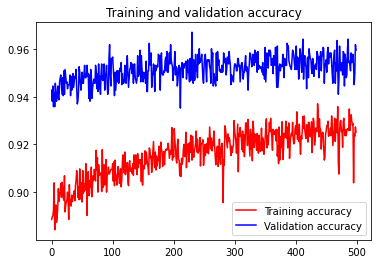

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

Run this code below to save the model as `savedmodel` format.


In [ ]:
tf.saved_model.save(model, '/content/savedmodel')

INFO:tensorflow:Assets written to: /content/savedmodel/assets


Run this code below to save the model as hdf5 file.

In [ ]:
model.save('/content/drive/MyDrive/Capstone Project/binary_model_ori_v5_64.h5')

To test the inference from the model, run this code below.

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

dictionary = {0:'0', 1:'1', 2 :'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'A',
    11:'B', 12:'C', 13:'D', 14:'E', 15:'F', 16:'G', 17:'H', 18:'I', 19:'J', 20:'K',
    21:'L', 22:'M', 23:'N', 24:'O', 25:'P', 26:'Q', 27:'R', 28:'S', 29:'T',
    30:'U', 31:'V', 32:'W', 33:'X', 34:'Y', 35:'Z'} # the inference result are in one-hot encoding format. This dictionary are used to decode it.
    
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path,color_mode='grayscale', target_size=(64, 64)) # because the model can only receive 64x64 grayscale images, we need to convert it.
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)
  print(fn)
  print(classes)
  result = np.argmax(classes)
  print(np.amax(classes)*100) # print model's confidence level
  
  print(dictionary[result])# print the inference result

Saving test1.jpg to test1.jpg
Saving test2.jpg to test2.jpg
Saving test3.jpg to test3.jpg
Saving test4.jpg to test4.jpg
Saving test5.jpg to test5.jpg
Saving test6.jpg to test6.jpg
Saving test7.jpg to test7.jpg
Saving test8.jpg to test8.jpg
test1.jpg
[[5.10595077e-09 8.48156589e-16 8.14504934e-15 6.35383088e-08
  1.15960725e-14 4.98222748e-11 4.16716887e-07 6.04319309e-16
  3.60677838e-02 1.90663112e-08 2.60003219e-09 9.63807881e-01
  1.84177570e-17 6.92445834e-09 1.83548185e-12 6.52090036e-13
  4.02127593e-12 1.49023350e-07 3.40557786e-18 9.86019556e-18
  8.10393040e-13 1.14803787e-18 3.34329867e-13 7.16544662e-12
  2.03264321e-08 3.63844947e-07 2.15227427e-08 1.23314981e-04
  4.40318232e-17 1.20366315e-15 1.57377854e-12 5.07821578e-15
  5.26839718e-11 8.98335077e-20 3.58313598e-17 7.22026022e-18]]
96.38078808784485
B
test2.jpg
[[4.2218208e-12 9.9991727e-01 1.3063388e-15 6.0996429e-12 4.8335321e-16
  2.5063665e-11 7.9654308e-18 5.4847847e-06 2.0551075e-27 3.3135397e-14
  8.9081093e-10 